<a href="https://colab.research.google.com/github/Sashank11/Brain-Tumor-Recognition-MRI-Deep-learning/blob/main/Brain_Tumor_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Recognition with mri using Deep learning


### 19BCE2484 Sashank Rijal
### 19BCE2520 Mickey Kumar Rouniyar
### 19BCE2550 Prason Poudel

## Importing Dataset and Required Libraries 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [ ]:
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 5.8 MB 7.2 MB/s 
     |████████████████████████████████| 1.4 MB 64.2 MB/s 
     |████████████████████████████████| 462 kB 72.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [3]:
tf.__version__

'2.8.2'

In [4]:
import zipfile
file_name = "/content/drive/MyDrive/dataset.zip"

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip")
zip_ref.extractall()
zip_ref.close()

## Getting the Data Ready.
 
1.   Load all training and testing data

2.   Pre-processing images

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images

5.   Dividing the dataset into Training and Validation sets





In [5]:


labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

x_train = [] 
y_train  = [] 
x_test = [] 
y_test = [] 

image_size = 200


for label in labels:
    trainPath = os.path.join('/content/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) 
        image = cv2.bilateralFilter(image, 2, 50, 50) 
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) 
        image = cv2.resize(image, (image_size, image_size)) 
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/content/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train)
x_test = np.array(x_test)
print(x_train.shape)
print(x_test.shape)

100%|██████████| 74/74 [00:00<00:00, 114.01it/s]


(2870, 200, 200, 3)
(394, 200, 200, 3)


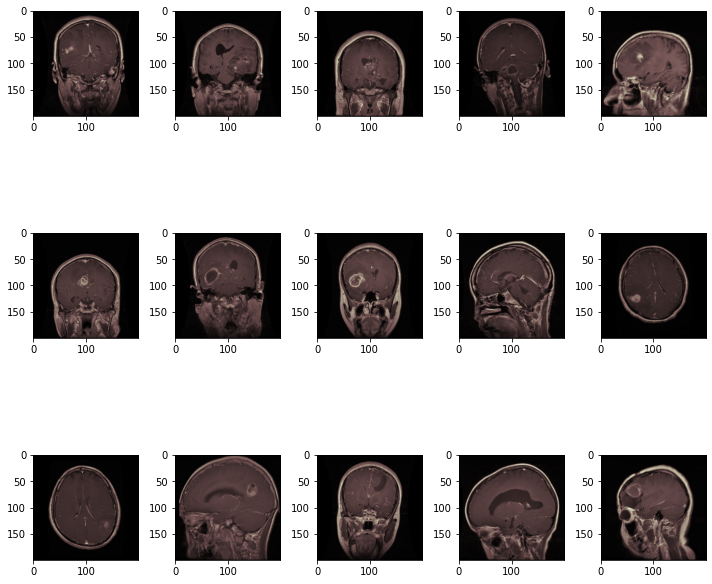

In [6]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [7]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) 

print(x_val.shape)

(574, 200, 200, 3)


## Data Augmentation


In [8]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Log confusion matrix to TensorBoard

With the following code you can log the confusion matrix for all epochs.

In [9]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# # Run tensorBoard
# %tensorboard --logdir logs

## Building our Custom Model

In [10]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
input_shape=(574, 200, 200, 3)
custom_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10, 
                         kernel_size = 3,
                         activation = "relu",
                         input_shape = input_shape[1:]),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.MaxPool2D(pool_size = 2,
                            padding = "valid"),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])
custom_model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), 
             metrics = ["accuracy"])

In [ ]:
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_c = custom_model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS)

Epoch 1/50
115/115 [==============================] - 30s 166ms/step - loss: 3.6336 - accuracy: 0.5039 - val_loss: 0.8973 - val_accuracy: 0.6376
Epoch 2/50
115/115 [==============================] - 19s 162ms/step - loss: 0.8478 - accuracy: 0.6341 - val_loss: 0.7048 - val_accuracy: 0.6969
Epoch 3/50
115/115 [==============================] - 23s 199ms/step - loss: 0.7575 - accuracy: 0.6642 - val_loss: 0.8846 - val_accuracy: 0.6429
Epoch 4/50
115/115 [==============================] - 19s 166ms/step - loss: 0.6679 - accuracy: 0.7073 - val_loss: 0.7544 - val_accuracy: 0.6725
Epoch 5/50
115/115 [==============================] - 18s 160ms/step - loss: 0.6601 - accuracy: 0.7173 - val_loss: 0.6934 - val_accuracy: 0.7195
Epoch 6/50
115/115 [==============================] - 19s 162ms/step - loss: 0.6653 - accuracy: 0.7117 - val_loss: 0.5548 - val_accuracy: 0.7631
Epoch 7/50
115/115 [==============================] - 19s 161ms/step - loss: 0.5706 - accuracy: 0.7539 - val_loss: 0.5526 - val_ac

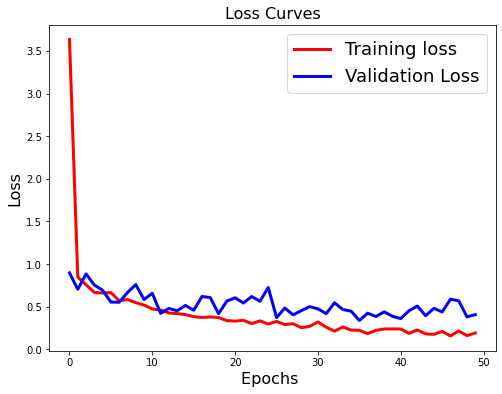

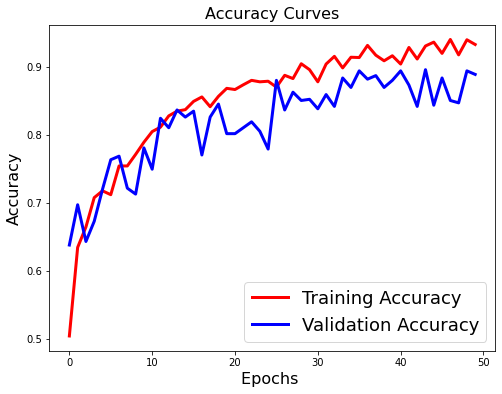

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_c.history['loss'],'r',linewidth=3.0)
plt.plot(history_c.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_c.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_c.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       186
           1       0.88      0.73      0.80       158
           2       0.88      0.92      0.90        71
           3       0.91      0.98      0.95       159

    accuracy                           0.89       574
   macro avg       0.89      0.89      0.89       574
weighted avg       0.89      0.89      0.89       574



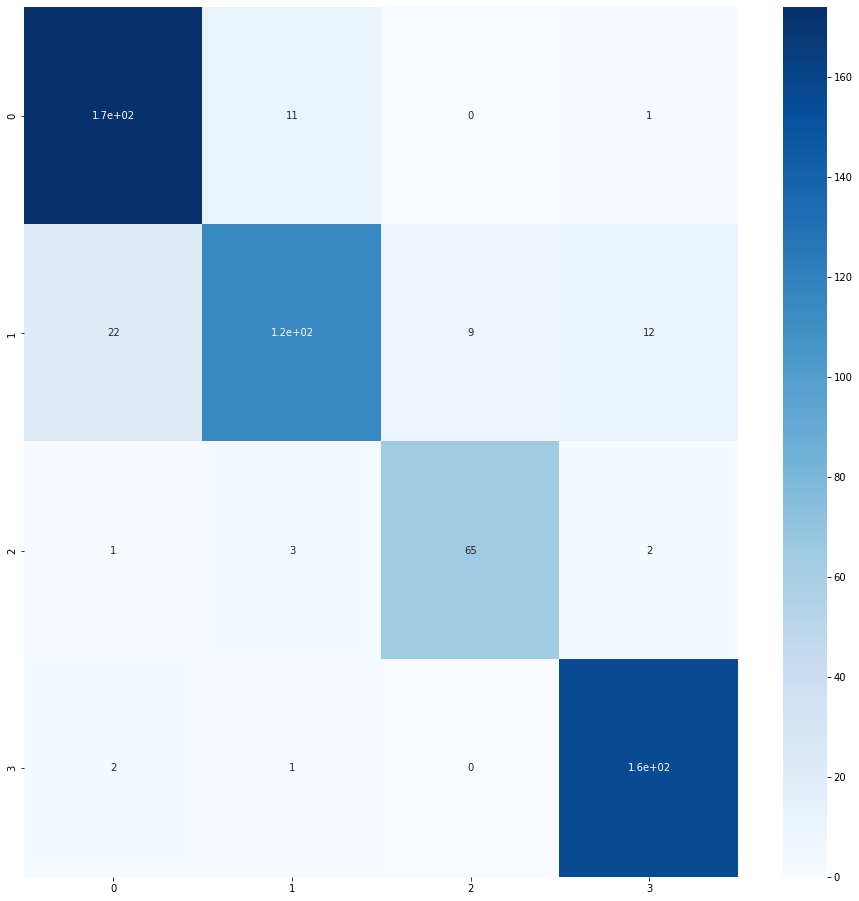

In [ ]:
predicted_classes = np.argmax(custom_model.predict(x_val), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_val,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_val,axis=1), predicted_classes))

In [ ]:
loss,acc = custom_model.evaluate(x_val,y_val)

18/18 [==============================] - 0s 15ms/step - loss: 0.4078 - accuracy: 0.8885


## Transfer Learning RestNet 50

In this project, We be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




In [ ]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:

#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_1 = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8275
Epoch 1: val_loss improved from inf to 13.72125, saving model to model-01-0.12-13.72.h5
115/115 [==============================] - 68s 370ms/step - loss: 0.4584 - accuracy: 0.8275 - val_loss: 13.7213 - val_accuracy: 0.1237 - lr: 1.0000e-04
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9347
Epoch 2: val_loss improved from 13.72125 to 8.99313, saving model to model-02-0.12-8.99.h5
115/115 [==============================] - 37s 323ms/step - loss: 0.2050 - accuracy: 0.9347 - val_loss: 8.9931 - val_accuracy: 0.1237 - lr: 1.0000e-04
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9495
Epoch 3: val_loss improved from 8.99313 to 6.05188, saving model to model-03-0.12-6.05.h5
115/115 [==============================] - 38s 331ms/step - loss: 0.1479 - accuracy: 0.9495 - val_loss: 6.0519 - val_accuracy: 0.1237 - lr: 

## Learning curves

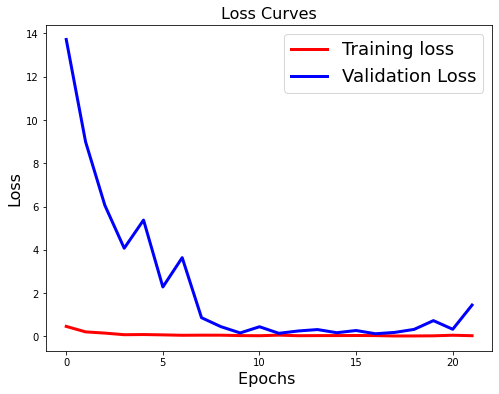

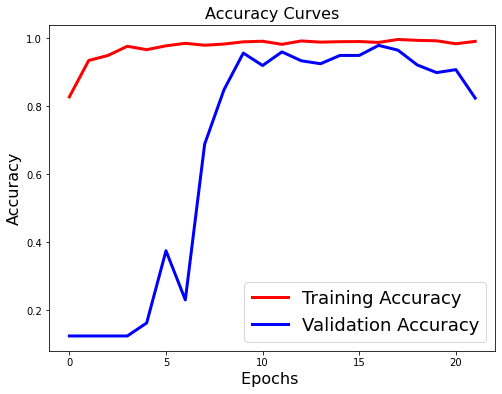

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['loss'],'r',linewidth=3.0)
plt.plot(history_1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       186
           1       0.97      0.97      0.97       158
           2       0.99      0.97      0.98        71
           3       0.98      0.99      0.98       159

    accuracy                           0.98       574
   macro avg       0.98      0.98      0.98       574
weighted avg       0.98      0.98      0.98       574



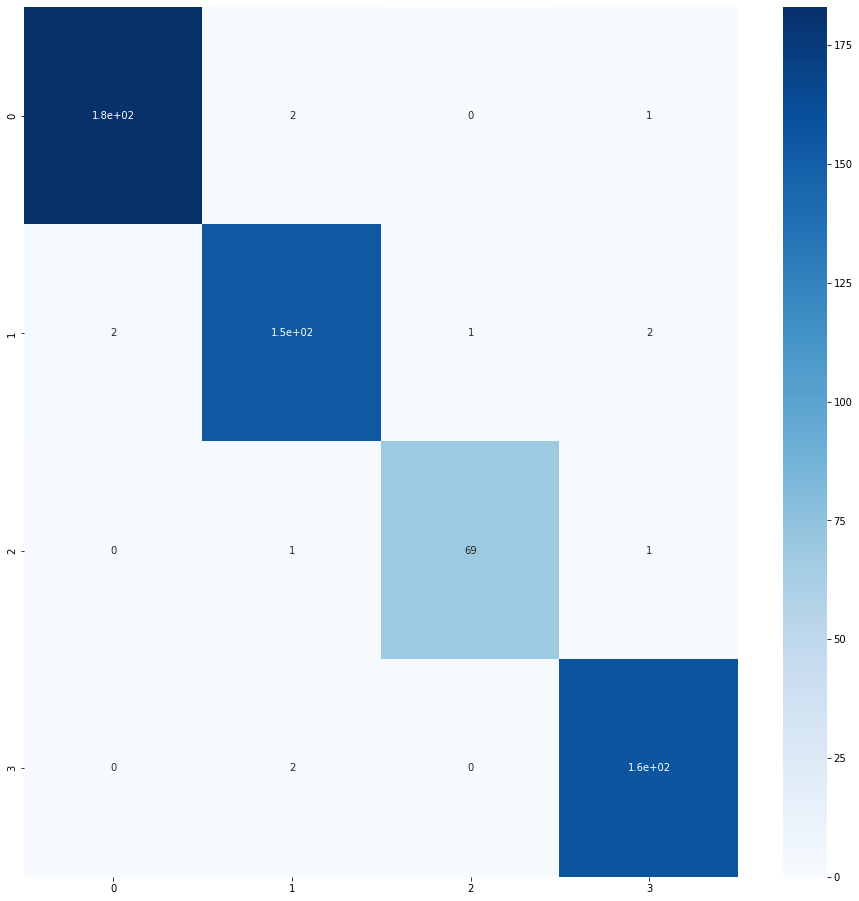

In [ ]:
predicted_classes = np.argmax(model.predict(x_val), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_val,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_val,axis=1), predicted_classes))

In [ ]:
loss,acc = model.evaluate(x_val,y_val)

18/18 [==============================] - 2s 96ms/step - loss: 0.1187 - accuracy: 0.9791


## Transfer Learning Inception_v3

In [12]:
inception = InceptionV3(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

87924736/87910968 [==============================] - 0s 0us/step


In [35]:
model = inception.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.6)(model)
# model = Dense(512, activation="relu")(model)
#model = Dense(256, activation="relu")(model)
#model = Dense(128, activation="relu")(model)
# model = Dropout(0.6)(model)
#model = Dense(32, activation="relu")(model)
#model = Dense(8, activation="relu")(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= inception.input, outputs= model)

#compile our model.
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [36]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_3 = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9085
Epoch 1: val_loss improved from inf to 0.32048, saving model to model-01-0.92-0.32.h5
115/115 [==============================] - 42s 295ms/step - loss: 0.2834 - accuracy: 0.9085 - val_loss: 0.3205 - val_accuracy: 0.9181 - lr: 1.0000e-04
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9578
Epoch 2: val_loss improved from 0.32048 to 0.31101, saving model to model-02-0.91-0.31.h5
115/115 [==============================] - 32s 280ms/step - loss: 0.1277 - accuracy: 0.9578 - val_loss: 0.3110 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9617
Epoch 3: val_loss did not improve from 0.31101
115/115 [==============================] - 31s 265ms/step - loss: 0.1181 - accuracy: 0.9617 - val_loss: 0.3223 - val_accuracy: 0.9181 - lr: 1.0000e-04
Epoch 4/50
115/115 [================

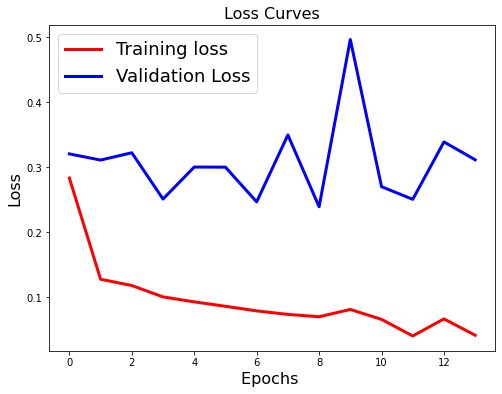

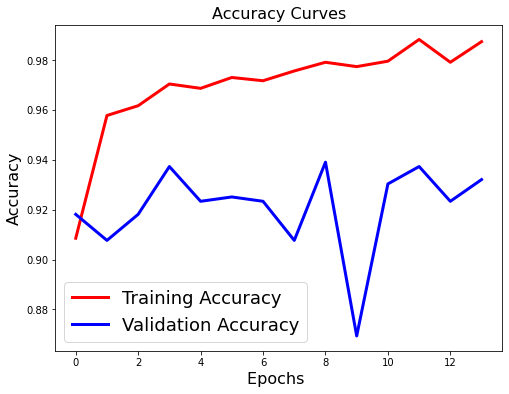

In [37]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_3.history['loss'],'r',linewidth=3.0)
plt.plot(history_3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       186
           1       0.86      0.83      0.84       158
           2       0.80      0.94      0.86        71
           3       0.94      0.96      0.95       159

    accuracy                           0.91       574
   macro avg       0.89      0.91      0.90       574
weighted avg       0.91      0.91      0.91       574



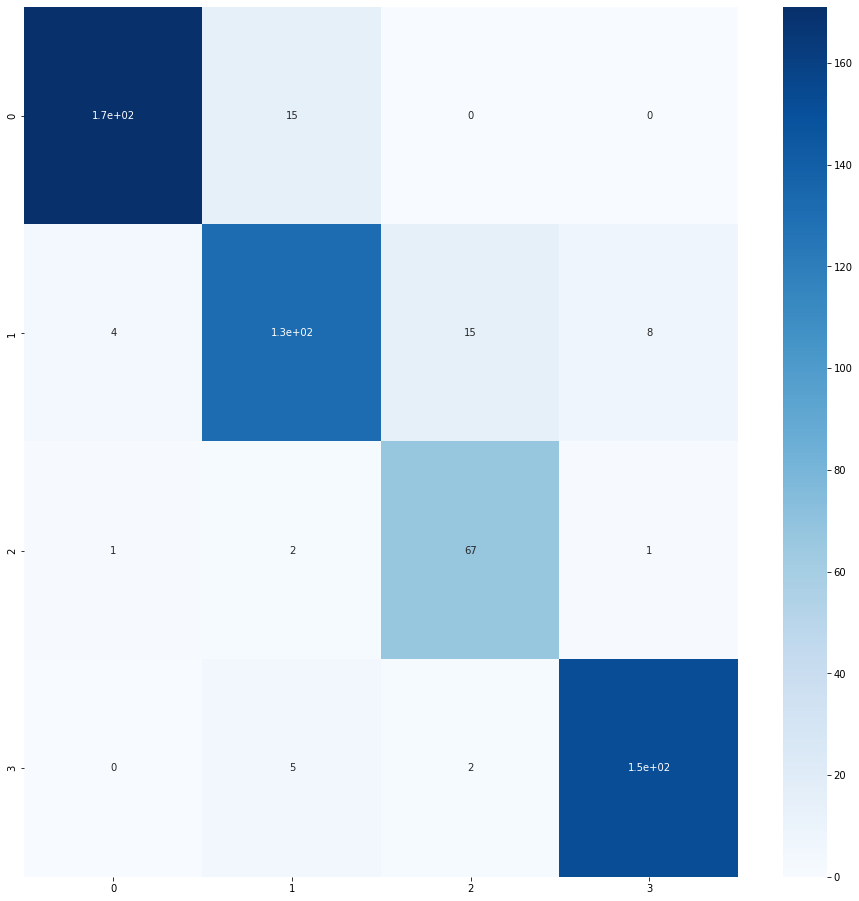

In [38]:
bpredicted_classes = np.argmax(model.predict(x_val), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_val,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_val,axis=1), predicted_classes))

In [41]:
loss,acc = model.evaluate(x_val,y_val)

18/18 [==============================] - 1s 65ms/step - loss: 0.2392 - accuracy: 0.9390


## Mobile Net_v2

In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [12]:
mobile_net = MobileNetV2(
     weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
flatten_layer = Flatten()
model = mobile_net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.9)(model)
model = flatten_layer(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= mobile_net.input, outputs= model)

#compile our model.
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [16]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_4 = model.fit(datagen.flow(x_train, y_train, batch_size=32),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.6995
Epoch 1: val_loss improved from inf to 2.26264, saving model to model-01-0.44-2.26.h5
72/72 [==============================] - 31s 379ms/step - loss: 0.8935 - accuracy: 0.6995 - val_loss: 2.2626 - val_accuracy: 0.4373 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8907
Epoch 2: val_loss improved from 2.26264 to 1.88244, saving model to model-02-0.54-1.88.h5
72/72 [==============================] - 26s 362ms/step - loss: 0.3102 - accuracy: 0.8907 - val_loss: 1.8824 - val_accuracy: 0.5401 - lr: 1.0000e-04
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9247
Epoch 3: val_loss improved from 1.88244 to 1.35686, saving model to model-03-0.64-1.36.h5
72/72 [==============================] - 26s 362ms/step - loss: 0.2113 - accuracy: 0.9247 - val_loss: 1.3569 - val_accuracy: 0.6411 - lr: 1.0000e-04
Epoch

## VGG 16

In [10]:
from keras.applications.vgg16 import VGG16

In [15]:
vgg = VGG16(
     weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False,# Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))


58900480/58889256 [==============================] - 0s 0us/step


In [27]:
flatten_layer = Flatten()
model = vgg.output
model = Dropout(0.5)(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = flatten_layer(model)
model = Dense(128, activation="relu")(model)
model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= vgg.input, outputs= model)
#compile our model.
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [28]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_4 = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2787
Epoch 1: val_loss did not improve from inf
115/115 [==============================] - 38s 323ms/step - loss: nan - accuracy: 0.2787 - val_loss: nan - val_accuracy: 0.3240 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2787
Epoch 2: val_loss did not improve from inf
115/115 [==============================] - 35s 302ms/step - loss: nan - accuracy: 0.2787 - val_loss: nan - val_accuracy: 0.3240 - lr: 0.0010
Epoch 3/50
 28/115 [======>.......................] - ETA: 21s - loss: nan - accuracy: 0.2875

KeyboardInterrupt: ignored